# TODO

0. do everything via sim to avoid confusion
1. remove t_stim arg from wrt stim func
2. calculate later theory and sim for comparison for t = 0 to 1. Need for truncation 
3. re-write the loop per ABL, ILD and calc area - all t, pos t


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from tqdm import tqdm
import random
from scipy.integrate import cumulative_trapezoid as cumtrapz

from time_vary_norm_utils import (
    up_or_down_RTs_fit_fn, cum_pro_and_reactive_time_vary_fn,
    rho_A_t_VEC_fn, up_or_down_RTs_fit_wrt_stim_fn)
from types import SimpleNamespace
import pickle

from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn
from tqdm.notebook import tqdm
from scipy.integrate import trapezoid as trapz

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [3]:
# LED off rows
df_led_off = df[ df['LED_trial'] == 0 ]
print(f'len df_led_off = {len(df_led_off)}')

# > 0 and < 1s valid rt 
df_led_off_valid = df_led_off[
    (df_led_off['timed_fix'] - df_led_off['intended_fix'] > 0) &
    (df_led_off['timed_fix'] - df_led_off['intended_fix'] < 1)
]

df_led_off_valid = df_led_off_valid[df_led_off_valid['response_poke'].isin([2,3])]

print(len(df_led_off_valid))

len df_led_off = 66226
52799


In [4]:
V_A = 1.596
theta_A = 2.531
t_A_aff = -0.226
del_go = 0.13

In [5]:
# phi params
bump_offset = 0
bump_width = 0.240
dip_width = 0.038
dip_height = 0.327

K_max = 10

# vbmc

In [6]:
is_norm = True
is_time_vary = True

## loglike fn

In [7]:
def compute_loglike(row, rate_lambda, T_0, theta_E, Z_E, t_E_aff, rate_norm_l, bump_height):
    
    timed_fix = row['timed_fix']
    intended_fix = row['intended_fix']
    
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = 2*row['response_poke'] - 5

    rt = timed_fix
    t_stim = intended_fix

    phi_params = {
        'h1': bump_width,
        'a1': bump_height,
        'h2': dip_width,
        'a2': dip_height,
        'b1': bump_offset
    }

    phi_params_obj = SimpleNamespace(**phi_params)
    
    trunc_factor_p_joint = cum_pro_and_reactive_time_vary_fn(
                            t_stim + 1,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max) \
                            - \
                            cum_pro_and_reactive_time_vary_fn(
                            t_stim,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max) + 1e-10
    P_joint_rt_choice = up_or_down_RTs_fit_fn(
                    rt, choice,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max)

    P_joint_rt_choice_trunc = max(P_joint_rt_choice / (trunc_factor_p_joint + 1e-10), 1e-10)
    return np.log(P_joint_rt_choice_trunc)
    
    


def vbmc_loglike_fn(params):
    rate_lambda, T_0, theta_E, Z_E, t_E_aff, rate_norm_l, bump_height = params
    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, rate_lambda, T_0, theta_E, Z_E, t_E_aff, rate_norm_l, bump_height)\
                                       for _, row in df_led_off_valid.iterrows() )
    return np.sum(all_loglike)


## priors

In [8]:
rate_lambda_bounds = [0.01, 0.2]
T_0_bounds = [0.1e-3, 1e-3]
theta_E_bounds = [5, 60]
Z_E_bounds = [-10, 10]
t_E_aff_bounds = [0.001, 0.1]
rate_norm_l_bounds = [0, 0.99]
bump_height_bounds = [0.02, 1]

rate_lambda_plausible_bounds = [0.05, 0.09]
T_0_plausible_bounds = [0.15e-3, 0.5e-3]
theta_E_plausible_bounds = [40, 55]
Z_E_plausible_bounds = [-5, 5]
t_E_aff_plausible_bounds = [0.01, 0.05]
rate_norm_l_plausible_bounds = [0.01, 0.8]  # example plausible range, can adjust
bump_height_plausible_bounds = [0.1, 0.5]


In [9]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    rate_lambda, T_0, theta_E, Z_E, t_E_aff, rate_norm_l, bump_height = params

    rate_lambda_logpdf = trapezoidal_logpdf(
        rate_lambda,
        rate_lambda_bounds[0],
        rate_lambda_plausible_bounds[0],
        rate_lambda_plausible_bounds[1],
        rate_lambda_bounds[1]
    )
    
    T_0_logpdf = trapezoidal_logpdf(
        T_0,
        T_0_bounds[0],
        T_0_plausible_bounds[0],
        T_0_plausible_bounds[1],
        T_0_bounds[1]
    )
    
    theta_E_logpdf = trapezoidal_logpdf(
        theta_E,
        theta_E_bounds[0],
        theta_E_plausible_bounds[0],
        theta_E_plausible_bounds[1],
        theta_E_bounds[1]
    )
    
    Z_E_logpdf = trapezoidal_logpdf(
        Z_E,
        Z_E_bounds[0],
        Z_E_plausible_bounds[0],
        Z_E_plausible_bounds[1],
        Z_E_bounds[1]
    )
    
    t_E_aff_logpdf = trapezoidal_logpdf(
        t_E_aff,
        t_E_aff_bounds[0],
        t_E_aff_plausible_bounds[0],
        t_E_aff_plausible_bounds[1],
        t_E_aff_bounds[1]
    )

    rate_norm_l_logpdf = trapezoidal_logpdf(
        rate_norm_l,
        rate_norm_l_bounds[0],
        rate_norm_l_plausible_bounds[0],
        rate_norm_l_plausible_bounds[1],
        rate_norm_l_bounds[1]
    )

    bump_height_logpdf = trapezoidal_logpdf(
        bump_height,
        bump_height_bounds[0],
        bump_height_plausible_bounds[0],
        bump_height_plausible_bounds[1],
        bump_height_bounds[1]
    )


    return (
        rate_lambda_logpdf +
        T_0_logpdf +
        theta_E_logpdf +
        Z_E_logpdf +
        t_E_aff_logpdf +
        rate_norm_l_logpdf + 
        bump_height_logpdf
    )


## prior + loglike

In [10]:
def vbmc_joint_fn(params):
    priors = vbmc_prior_fn(params)
    loglike = vbmc_loglike_fn(params)

    return priors + loglike

# run vbmc

In [11]:
# Add bounds for all parameters
lb = np.array([
    rate_lambda_bounds[0],
    T_0_bounds[0],
    theta_E_bounds[0],
    Z_E_bounds[0],
    t_E_aff_bounds[0],
    rate_norm_l_bounds[0],
    bump_height_bounds[0]
])

ub = np.array([
    rate_lambda_bounds[1],
    T_0_bounds[1],
    theta_E_bounds[1],
    Z_E_bounds[1],
    t_E_aff_bounds[1],
    rate_norm_l_bounds[1],
    bump_height_bounds[1]
])

plb = np.array([
    rate_lambda_plausible_bounds[0],
    T_0_plausible_bounds[0],
    theta_E_plausible_bounds[0],
    Z_E_plausible_bounds[0],
    t_E_aff_plausible_bounds[0],
    rate_norm_l_plausible_bounds[0],
    bump_height_plausible_bounds[0]
])

pub = np.array([
    rate_lambda_plausible_bounds[1],
    T_0_plausible_bounds[1],
    theta_E_plausible_bounds[1],
    Z_E_plausible_bounds[1],
    t_E_aff_plausible_bounds[1],
    rate_norm_l_plausible_bounds[1],
    bump_height_plausible_bounds[1]
])

# Initialize with random values within plausible bounds
np.random.seed(42)
rate_lambda_0 = np.random.uniform(*rate_lambda_plausible_bounds)
T_0_0 = np.random.uniform(*T_0_plausible_bounds)
theta_E_0 = np.random.uniform(*theta_E_plausible_bounds)
Z_E_0 = np.random.uniform(*Z_E_plausible_bounds)
t_E_aff_0 = np.random.uniform(*t_E_aff_plausible_bounds)
rate_norm_l_0 = np.random.uniform(*rate_norm_l_plausible_bounds)
bump_height_0 = np.random.uniform(*bump_height_plausible_bounds)

x_0 = np.array([
    rate_lambda_0,
    T_0_0,
    theta_E_0,
    Z_E_0,
    t_E_aff_0,
    rate_norm_l_0,
    bump_height_0
])

# Run VBMC
vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 7).
Reshaping upper bounds to (1, 7).
Reshaping plausible lower bounds to (1, 7).
Reshaping plausible upper bounds to (1, 7).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       19255.42      3198.93          inf        2        inf     start warm-up
     1         15       19984.17      5589.73      2146.88        2        inf     
     2         20       24086.10      2251.28      3229.43        2   6.19e+04     
     3         25       24974.89      1508.16      4485.64        2   6.45e+04     
     4         30       24722.24       620.09     15547.77        2   1.99e+05     
     5         35       24512.48       220.68       401.54        2   6.49e+03     
     6         40       24514.82        72.03        99.69        2    1.5e+03     
     7         45       24750.82       574.1

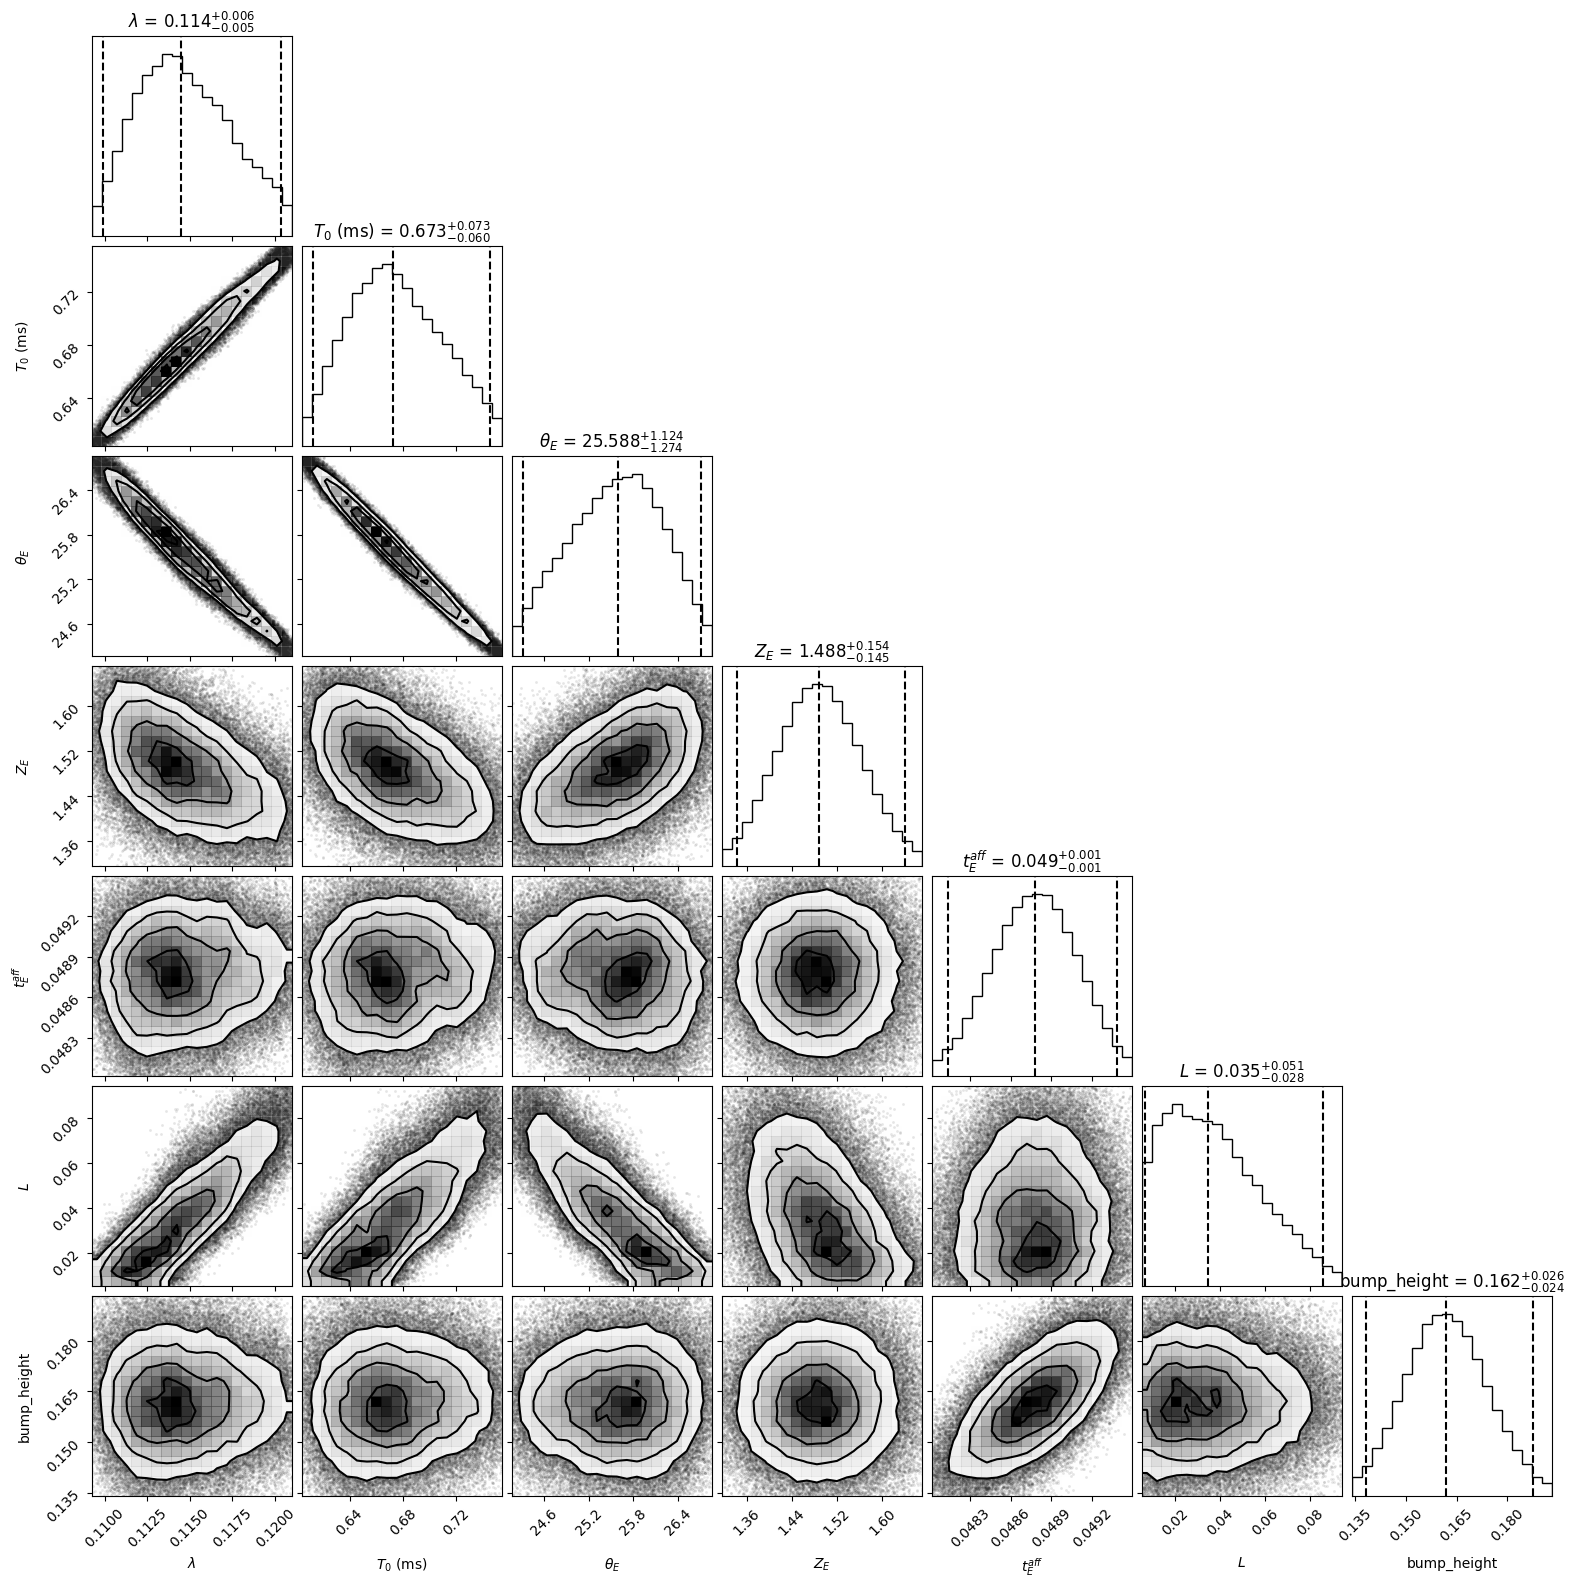

In [12]:
# Sample from the VBMC posterior (returns tuple: samples, log weights)
vp_samples = vp.sample(int(1e5))[0]

# Convert T_0 to ms
vp_samples[:, 1] *= 1e3  # T_0 is at index 1

# Parameter labels (order matters!)
param_labels = [r'$\lambda$', r'$T_0$ (ms)', r'$\theta_E$', r'$Z_E$', r'$t_{E}^{aff}$', r'$L$', 'bump_height']

# Compute 1st and 99th percentiles for each param to restrict range
percentiles = np.percentile(vp_samples, [1, 99], axis=0)
_ranges = [(percentiles[0, i], percentiles[1, i]) for i in range(vp_samples.shape[1])]

# Create the corner plot
fig = corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".3f"
)

vp_samples[:, 1] /= 1e3  # T_0 is at index 1


plt.show()


# diagnostics

In [13]:
rate_lambda = vp_samples[:, 0].mean()
T_0 = vp_samples[:, 1].mean()
theta_E = vp_samples[:, 2].mean()
Z_E = vp_samples[:, 3].mean()
t_E_aff = vp_samples[:, 4].mean()
rate_norm_l = vp_samples[:, 5].mean()
bump_height = vp_samples[:, 6].mean()

# Print them out
print("Posterior Means:")
print(f"rate_lambda  = {rate_lambda:.5f}")
print(f"T_0 (ms)      = {1e3*T_0:.5f}")
print(f"theta_E       = {theta_E:.5f}")
print(f"Z_E           = {Z_E:.5f}")
print(f"t_E_aff       = {1e3*t_E_aff:.5f} ms")
print(f"rate_norm_l   = {rate_norm_l:.5f}")
print(f'bump height = {bump_height :.5f}')


Posterior Means:
rate_lambda  = 0.11470
T_0 (ms)      = 0.67498
theta_E       = 25.55786
Z_E           = 1.48858
t_E_aff       = 48.77318 ms
rate_norm_l   = 0.03780
bump height = 0.16210


# up and down RTD

In [79]:
N_theory = int(1e3)
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(-1, 2, 0.001)

P_A_samples = np.zeros((N_theory, len(t_pts)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    pdf = rho_A_t_VEC_fn(t_pts - t_A_aff + t_stim, V_A, theta_A)
    P_A_samples[idx, :] = pdf

P_A_samples_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

# per stim, up and down RTD

### ABL = 20, ILD = -16.0 ###
theory areas:
Up: 0.091, down=0.909, up + down = 1.000
data areas:
up = 0.084, down = 0.916, up + down = 1.000
### ABL = 20, ILD = -8.0 ###
theory areas:
Up: 0.171, down=0.829, up + down = 1.000
data areas:
up = 0.096, down = 0.904, up + down = 1.000
### ABL = 20, ILD = -4.0 ###
theory areas:
Up: 0.303, down=0.697, up + down = 1.000
data areas:
up = 0.157, down = 0.843, up + down = 1.000
### ABL = 20, ILD = -2.0 ###
theory areas:
Up: 0.406, down=0.594, up + down = 1.000
data areas:
up = 0.276, down = 0.724, up + down = 1.000
### ABL = 20, ILD = -1.0 ###
theory areas:
Up: 0.464, down=0.536, up + down = 1.000
data areas:
up = 0.382, down = 0.618, up + down = 1.000
### ABL = 20, ILD = 1.0 ###
theory areas:
Up: 0.584, down=0.416, up + down = 1.000
data areas:
up = 0.604, down = 0.396, up + down = 1.000
### ABL = 20, ILD = 2.0 ###
theory areas:
Up: 0.640, down=0.360, up + down = 1.000
data areas:
up = 0.710, down = 0.290, up + down = 1.000
### ABL = 20, ILD = 4

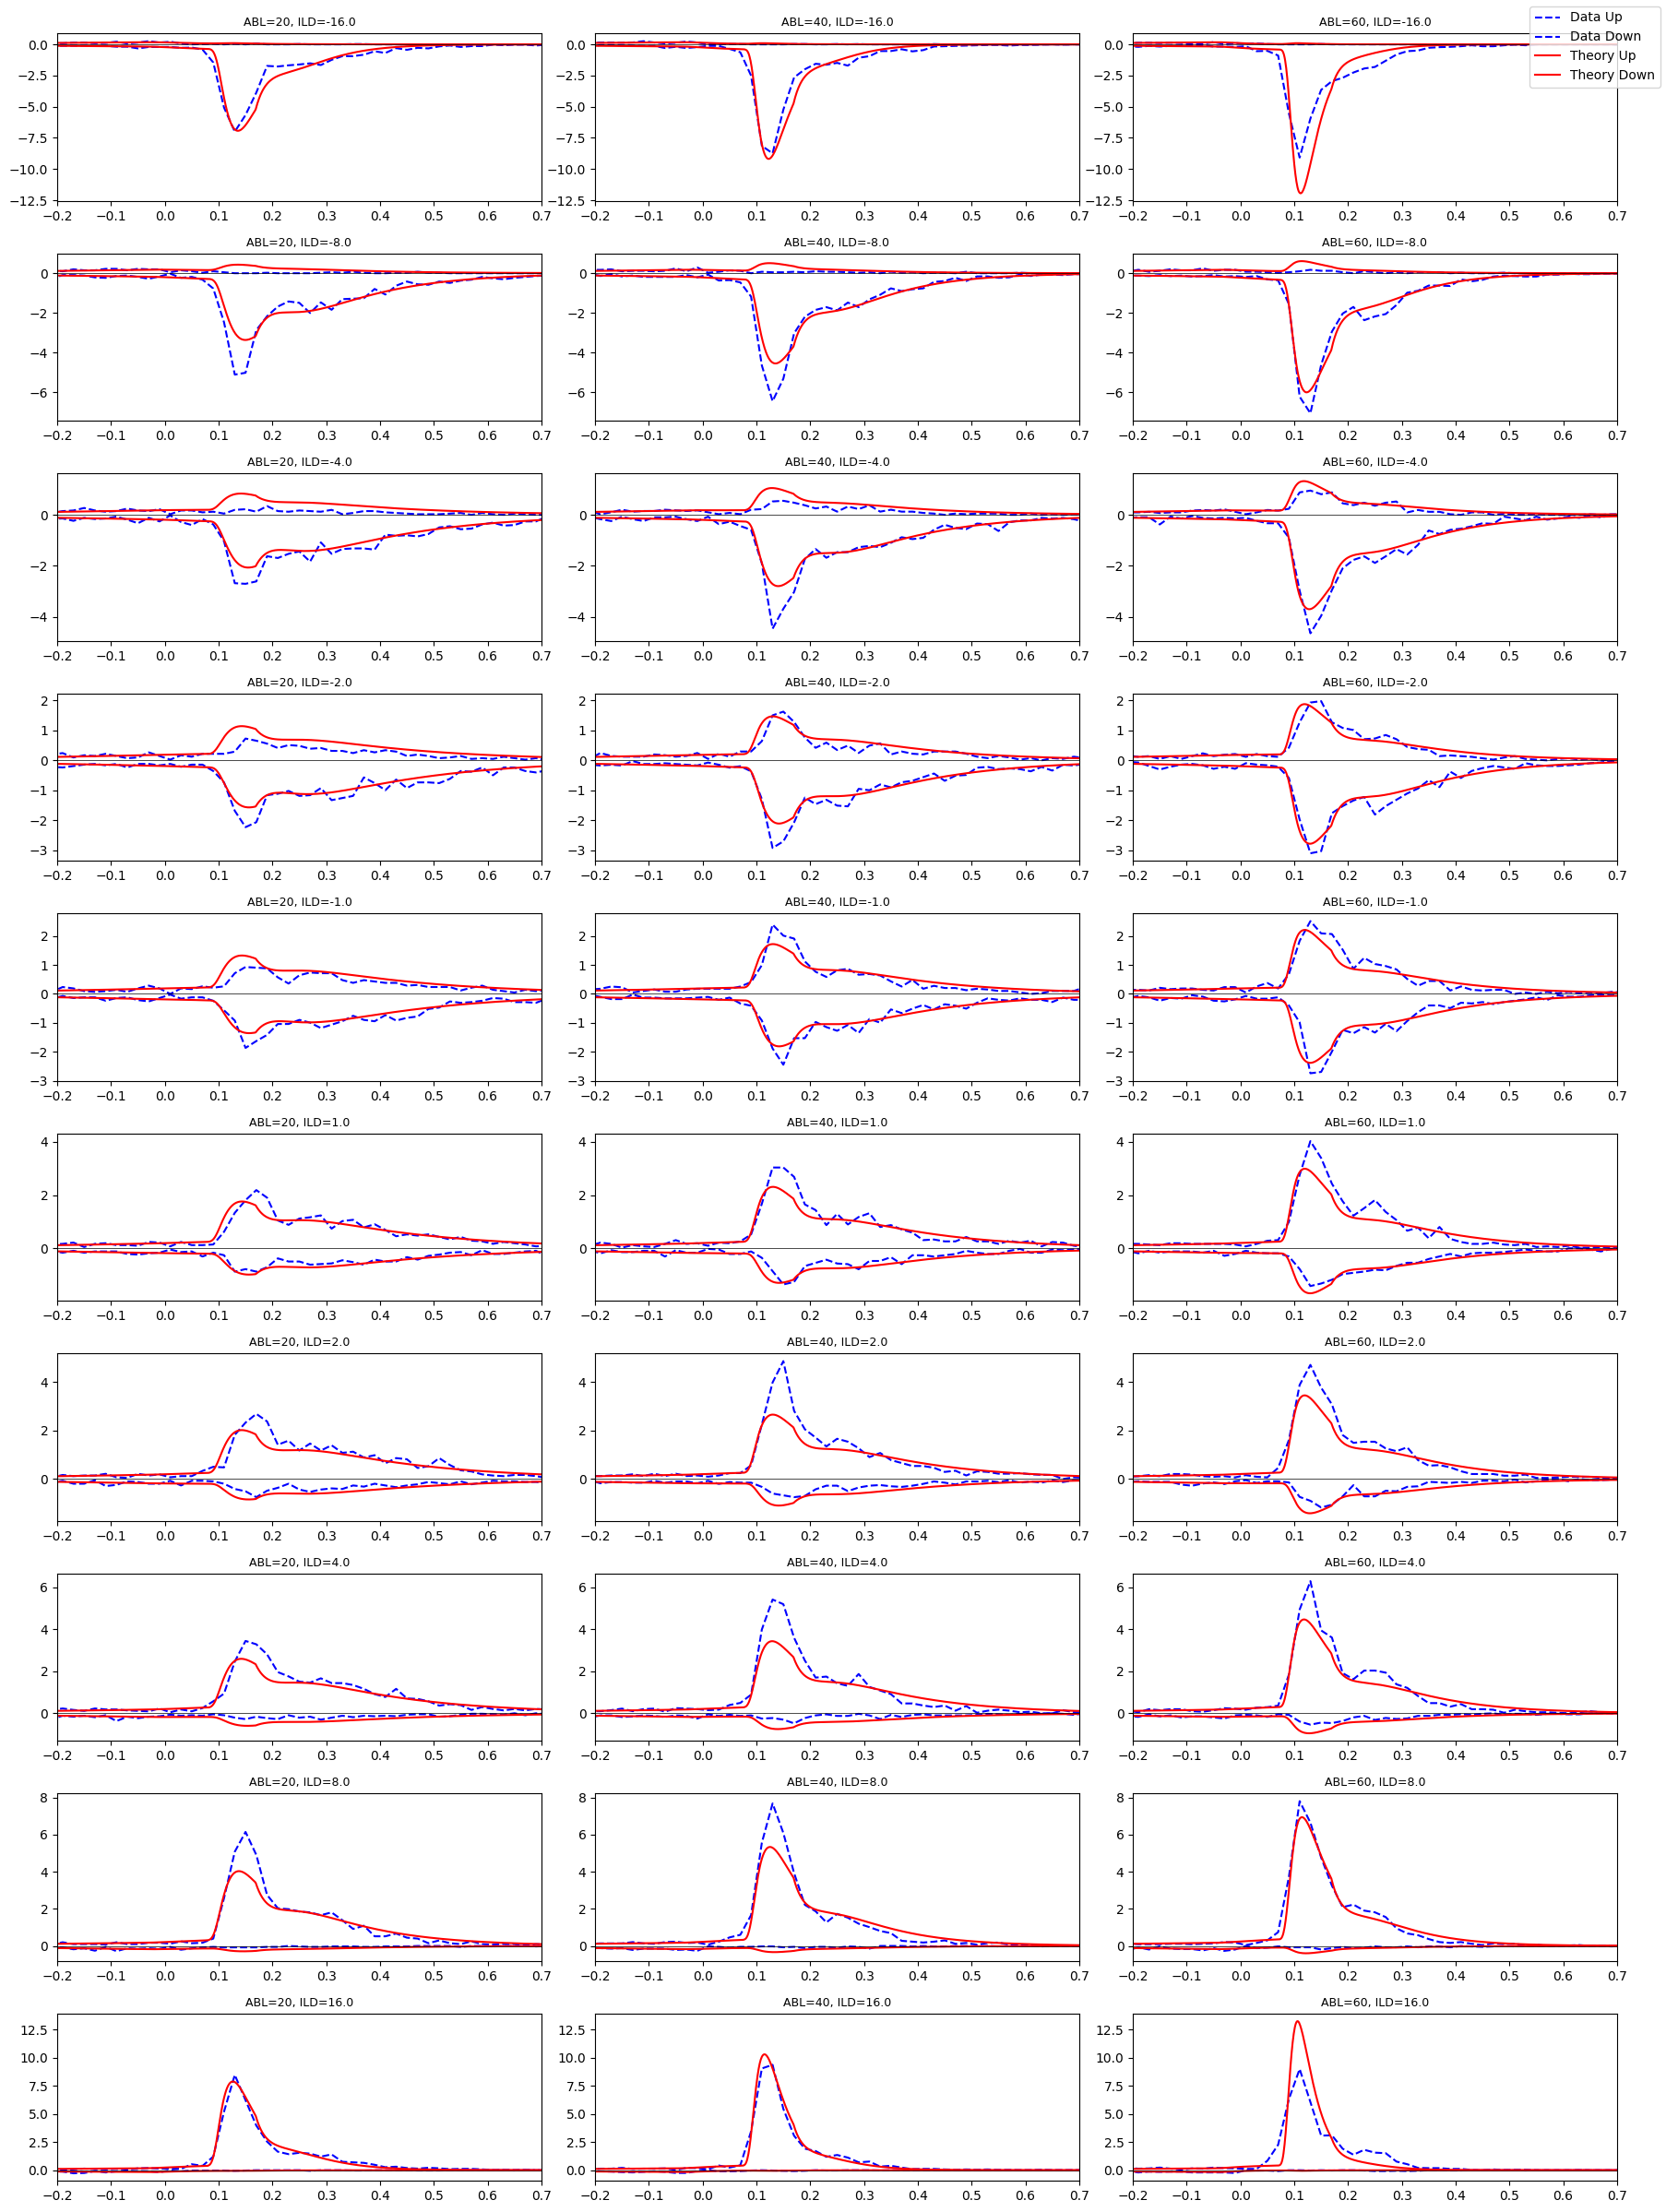

In [80]:
# Create figure and axes row by row to enable row-wise shared Y axes
fig = plt.figure(figsize=(18, 24))
axes = []

for i in range(10):  # 10 rows
    row_axes = []
    for j in range(3):  # 3 columns
        ax = fig.add_subplot(10, 3, i * 3 + j + 1, sharey=row_axes[0] if row_axes else None)
        row_axes.append(ax)
    axes.append(row_axes)

fig.subplots_adjust(hspace=0.8, wspace=0.4)

bin_size = 0.02
bins = np.arange(-1, 2, bin_size)
bin_centers = bins[:-1] + (bin_size / 2)
t_pts = np.arange(-1, 2, 0.001)

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}
phi_params_obj = SimpleNamespace(**phi_params)

# Plotting
for a_idx, ABL in enumerate(ABL_arr):
    for i_idx, ILD in enumerate(ILD_arr):
        ax = axes[i_idx][a_idx]  # axes[row][col] = (ILD, ABL)

        # data
        # ONLY valid
        # df_ABL_ILD = df_led_off_valid[
        #     (df_led_off_valid['ABL'] == ABL) & (df_led_off_valid['ILD'] == ILD)]
        # valid + aborts
        df_led_off_abort_and_valid = df_led_off[(df_led_off['abort_event'] == 3) | (df_led_off['response_poke'].isin([2,3]))]
        mask_invalid = ~df_led_off_abort_and_valid['response_poke'].isin([2, 3])
        # Step 2: Assign random values (2 or 3 with 50% chance) to those rows
        df_led_off_abort_and_valid.loc[mask_invalid, 'response_poke'] = np.random.choice([2, 3], size=mask_invalid.sum())

        df_ABL_ILD = df_led_off_abort_and_valid[
            (df_led_off_abort_and_valid['ABL'] == ABL) & (df_led_off_abort_and_valid['ILD'] == ILD)]
        df_ABL_ILD_up = df_ABL_ILD[df_ABL_ILD['response_poke'] == 3]
        df_ABL_ILD_down = df_ABL_ILD[df_ABL_ILD['response_poke'] == 2]

        df_ABL_ILD_up_rt = df_ABL_ILD_up['timed_fix'] - df_ABL_ILD_up['intended_fix']
        df_ABL_ILD_down_rt = df_ABL_ILD_down['timed_fix'] - df_ABL_ILD_down['intended_fix']

        data_up_rt_hist, _ = np.histogram(df_ABL_ILD_up_rt, bins=bins, density=True)
        data_down_rt_hist, _ = np.histogram(df_ABL_ILD_down_rt, bins=bins, density=True)

        data_frac_up = len(df_ABL_ILD_up) / len(df_ABL_ILD)
        data_frac_down = len(df_ABL_ILD_down) / len(df_ABL_ILD)

        # theory
        theory_ABL_ILD_up = np.zeros_like(t_pts)
        theory_ABL_ILD_down = np.zeros_like(t_pts)

        for idx, t in enumerate(t_pts):
            P_A = P_A_samples_mean[idx]
            C_A = C_A_mean[idx]
            theory_ABL_ILD_up[idx] = up_or_down_RTs_fit_wrt_stim_fn(
                t, 1, P_A, C_A,
                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                phi_params_obj, rate_norm_l, is_norm, is_time_vary, K_max)

            theory_ABL_ILD_down[idx] = up_or_down_RTs_fit_wrt_stim_fn(
                t, -1, P_A, C_A,
                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                phi_params_obj, rate_norm_l, is_norm, is_time_vary, K_max)

        ax.plot(bin_centers, data_up_rt_hist * data_frac_up, 'b--', label='Data Up' if i_idx == 0 and a_idx == 0 else "")
        ax.plot(bin_centers, -data_down_rt_hist * data_frac_down, 'b--', label='Data Down' if i_idx == 0 and a_idx == 0 else "")
        ax.plot(t_pts, theory_ABL_ILD_up, 'r-', label='Theory Up' if i_idx == 0 and a_idx == 0 else "")
        ax.plot(t_pts, -theory_ABL_ILD_down, 'r-', label='Theory Down' if i_idx == 0 and a_idx == 0 else "")
        print(f'### ABL = {ABL}, ILD = {ILD} ###')
        print(f'theory areas:')
        theory_area_up = trapz(theory_ABL_ILD_up, t_pts); theory_area_down = trapz(theory_ABL_ILD_down, t_pts)
        print(f'Up: {theory_area_up :.3f}, down={theory_area_down :.3f}, up + down = {(theory_area_up  + theory_area_down) :.3f}')
        print(f'data areas:')
        print(f'up = {data_frac_up :.3f}, down = {data_frac_down :.3f}, up + down = {(data_frac_up + data_frac_down) :.3f}')
        ax.set_title(f'ABL={ABL}, ILD={ILD}', fontsize=9)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_xlim(-0.2, 0.7)

# Add a single legend outside the plot
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.98, 1])
plt.show()


# tacho

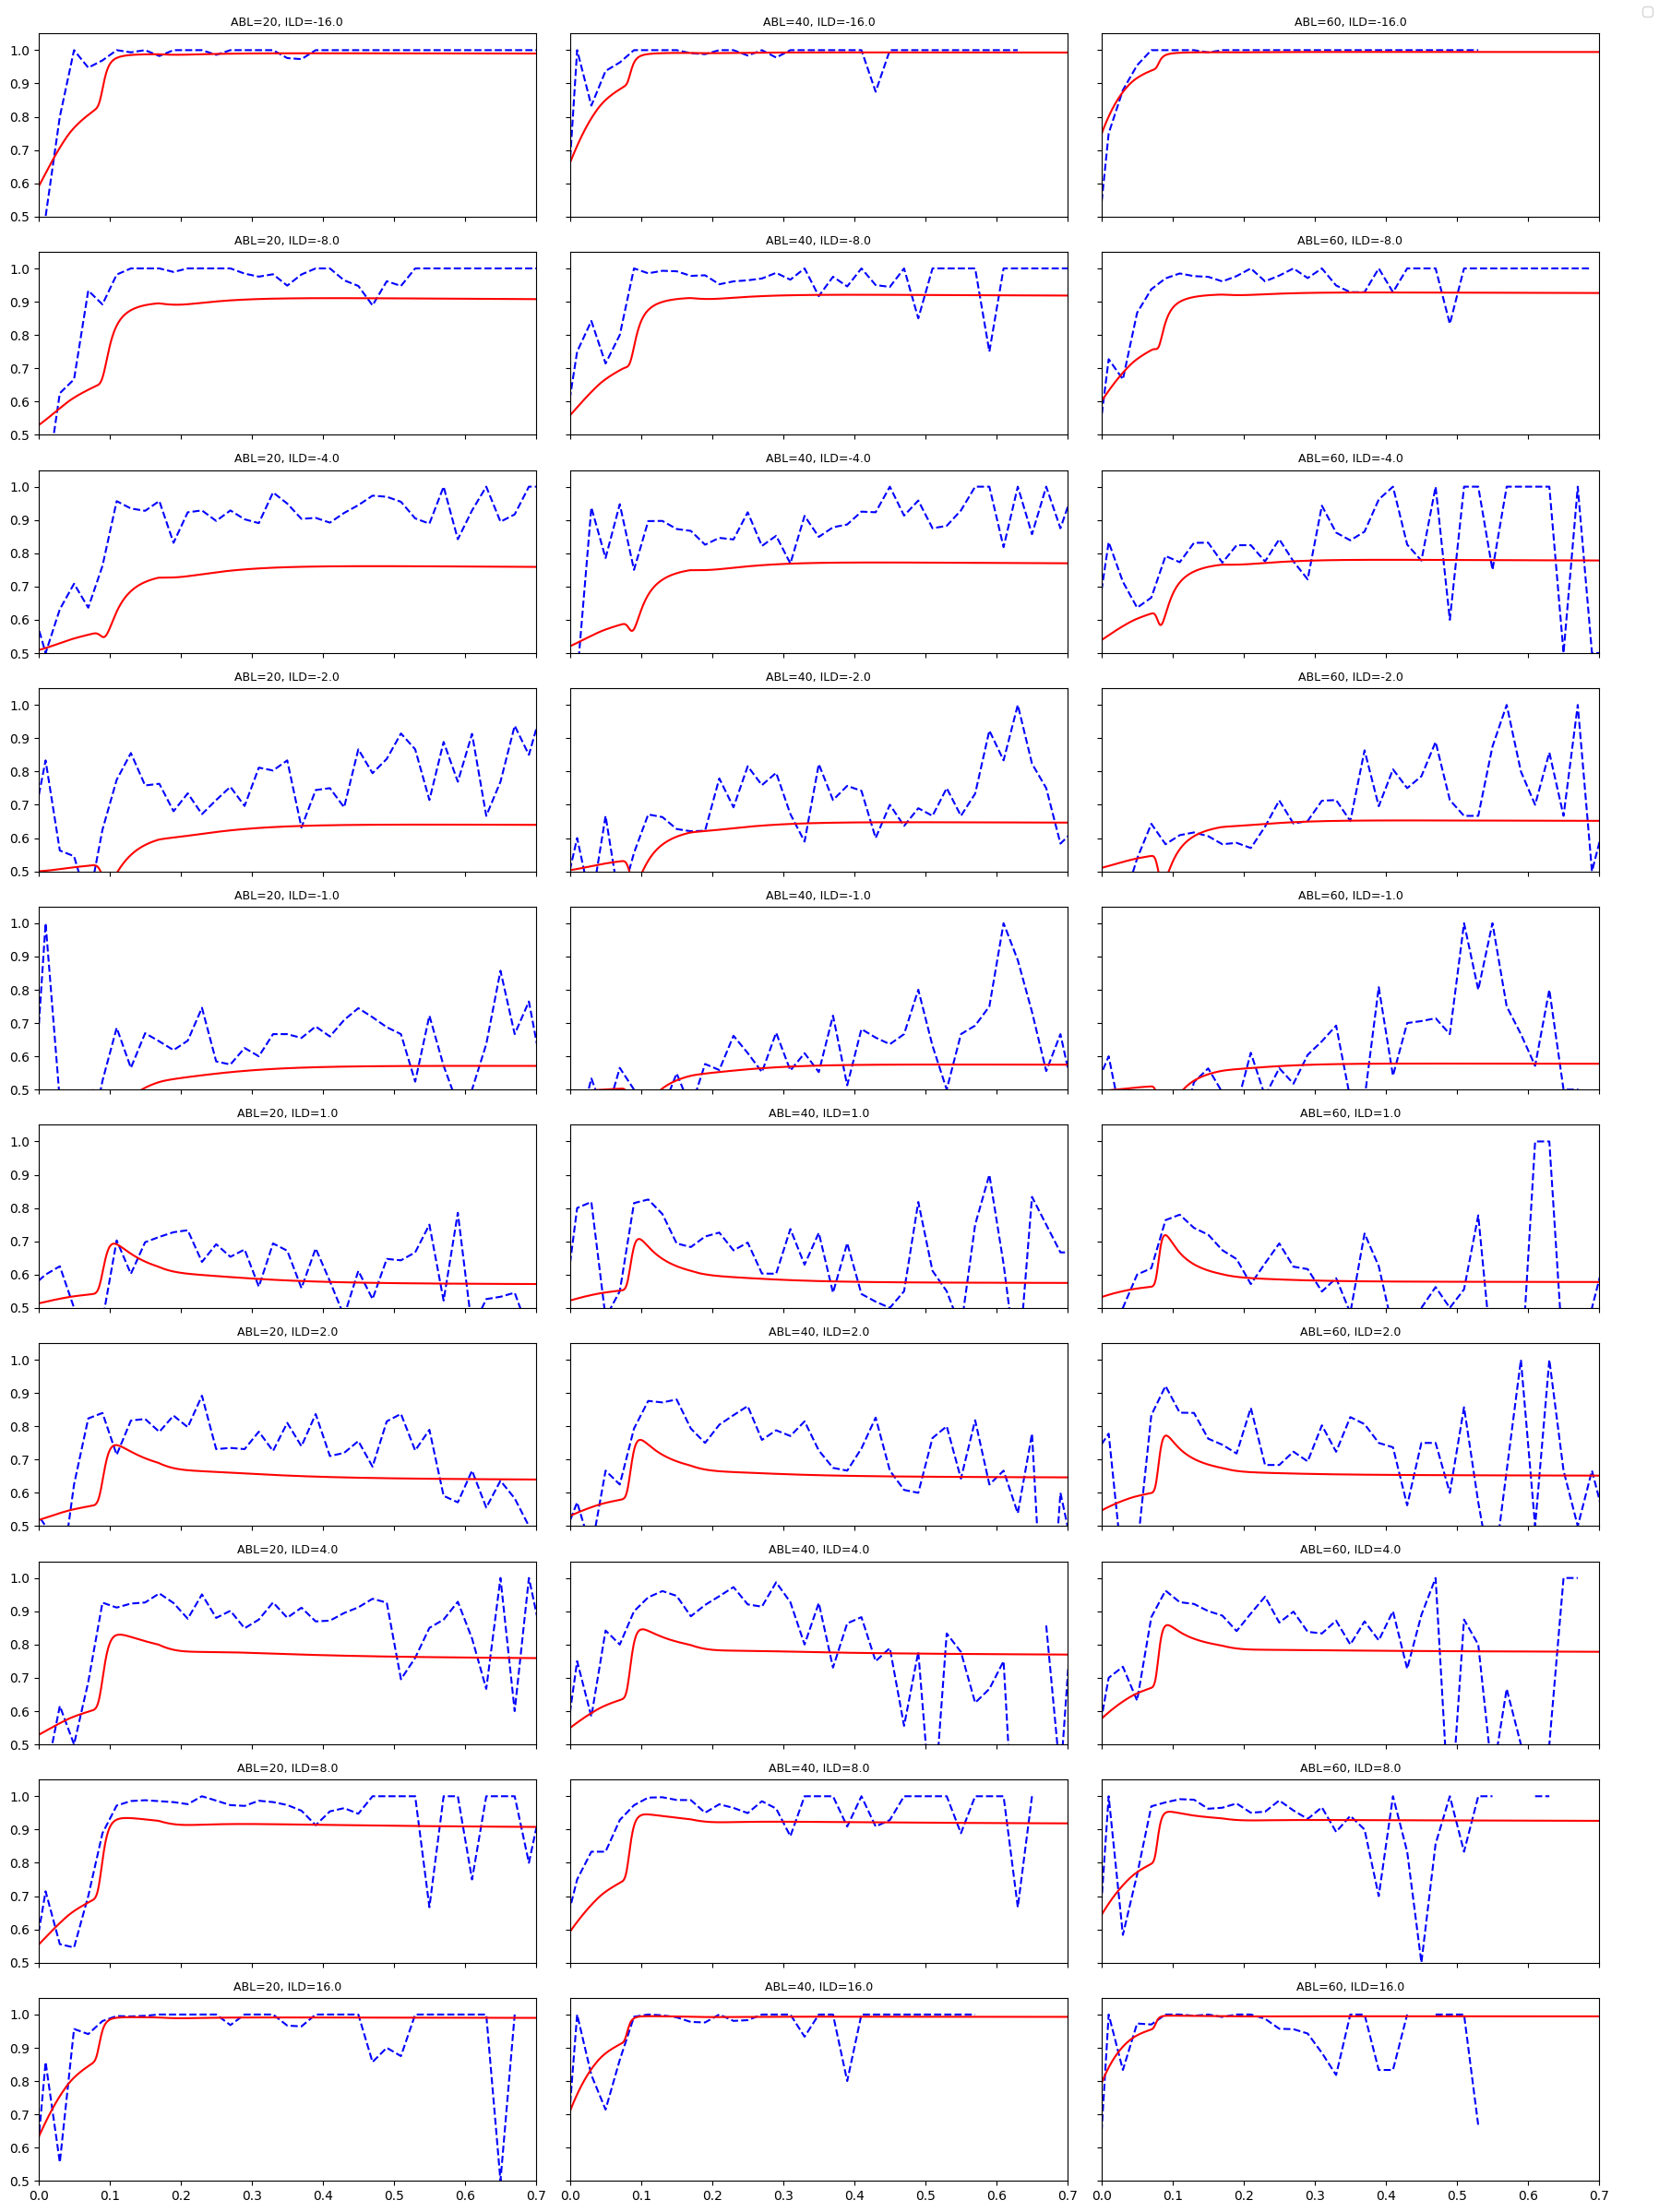

In [61]:
import matplotlib.pyplot as plt

# Prepare the figure and axes
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(18, 24), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
bin_size = 0.02
bins = np.arange(-1, 2, bin_size)
bin_centers = bins[:-1] + (bin_size / 2)
t_pts = np.arange(-1, 2, 0.001)


for a_idx, ABL in enumerate(ABL_arr):
    for i_idx, ILD in enumerate(ILD_arr):
        ax = axes[i_idx, a_idx]  # (row=ILD, col=ABL)

        # data
        df_led_off_abort_and_valid = df_led_off[(df_led_off['abort_event'] == 3) | (df_led_off['response_poke'].isin([2,3]))]
        mask_invalid = ~df_led_off_abort_and_valid['response_poke'].isin([2, 3])
        # Step 2: Assign random values (2 or 3 with 50% chance) to those rows
        df_led_off_abort_and_valid.loc[mask_invalid, 'response_poke'] = np.random.choice([2, 3], size=mask_invalid.sum())

        df_ABL_ILD = df_led_off_abort_and_valid[
            (df_led_off_abort_and_valid['ABL'] == ABL) & (df_led_off_abort_and_valid['ILD'] == ILD)].copy()
        
        # df_ABL_ILD = df_led_off_valid[
        #     (df_led_off_valid['ABL'] == ABL) & (df_led_off_valid['ILD'] == ILD)].copy()
        
        df_ABL_ILD.loc[:, 'RT'] = df_ABL_ILD['timed_fix'] - df_ABL_ILD['intended_fix']
        df_ABL_ILD.loc[:, 'is_correct'] = (
                    df_ABL_ILD['ILD'] * (2 * df_ABL_ILD['response_poke'] - 5)
                ) > 0
        df_ABL_ILD.loc[:, 'rt_bin'] = pd.cut(
                df_ABL_ILD['RT'], bins=bins, include_lowest=True
            )
        tachometric_curve = df_ABL_ILD.groupby('rt_bin', observed=False)['is_correct'].mean()


        # theory
        theory_ABL_ILD_up = np.zeros_like(t_pts)
        theory_ABL_ILD_down = np.zeros_like(t_pts)
        theory_tacho = np.zeros_like(t_pts)
        for idx, t in enumerate(t_pts):
            P_A = P_A_samples_mean[idx]
            C_A = C_A_mean[idx]
            theory_ABL_ILD_up[idx] = up_or_down_RTs_fit_wrt_stim_fn(
                t, 1,
                P_A, C_A,
                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                phi_params_obj, rate_norm_l,
                is_norm, is_time_vary, K_max)

            theory_ABL_ILD_down[idx] = up_or_down_RTs_fit_wrt_stim_fn(
                t, -1,
                P_A, C_A,
                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                phi_params_obj, rate_norm_l,
                is_norm, is_time_vary, K_max)

            if ILD > 0:
                theory_tacho[idx] = theory_ABL_ILD_up[idx] / (theory_ABL_ILD_up[idx] + theory_ABL_ILD_down[idx] + 1e-10)
            else:
                theory_tacho[idx] = theory_ABL_ILD_down[idx] / (theory_ABL_ILD_up[idx] + theory_ABL_ILD_down[idx] + 1e-10)
        

        ax.plot(bin_centers, tachometric_curve, 'b--')
        ax.plot(t_pts, theory_tacho, 'r-')
        ax.set_title(f'ABL={ABL}, ILD={ILD}', fontsize=9)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_xlim(0, 0.7)
        ax.set_ylim(0.5, 1.05)

# Add shared axis labels

# Add a single legend outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.98, 1])  # leave space for legend
plt.show()


# check with simulations 

In [18]:
# sample t-stim
N_sim = int(1e6)

t_stim_samples = df['intended_fix'].sample(N_sim, replace=True).values
ABL_samples = df['ABL'].sample(N_sim, replace=True).values
ILD_samples = df['ILD'].sample(N_sim, replace=True).values

N_print = int(N_sim / 5)
dt  = 1e-4

In [19]:
sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
        V_A, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim_samples[iter_num], rate_norm_l, iter_num, N_print, phi_params_obj, dt
    ) for iter_num in tqdm(range(N_sim))
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

os id: 936677, In iter_num: 0, ABL: 60, ILD: 8.0, t_stim: 0.33960578730572
os id: 936634, In iter_num: 200000, ABL: 60, ILD: -1.0, t_stim: 0.398201635881607
os id: 936682, In iter_num: 400000, ABL: 20, ILD: -4.0, t_stim: 0.371310623521116
os id: 936680, In iter_num: 600000, ABL: 40, ILD: 4.0, t_stim: 0.342199442572725
os id: 936672, In iter_num: 800000, ABL: 20, ILD: -1.0, t_stim: 0.411455848377493


# Grand RT, Grand Tacho, Psycho

In [25]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df_valid = sim_results_df[sim_results_df['rt'] > sim_results_df['t_stim']]
sim_results_df_valid_less_than_1 = sim_results_df_valid[sim_results_df_valid['rt'] - sim_results_df_valid['t_stim'] < 1].copy()

df_led_off_valid.loc[:,'choice'] = 2*df_led_off_valid['response_poke'] - 5
df_led_off_valid_renamed = df_led_off_valid.rename(columns={
    'timed_fix': 'rt',
    'intended_fix': 't_stim'
}).copy()

df_led_off_valid_renamed.loc[:,'correct'] = (df_led_off_valid_renamed['choice'] * df_led_off_valid_renamed['ILD'] > 0).astype(int)
sim_results_df_valid_less_than_1.loc[:,'correct'] = (sim_results_df_valid_less_than_1['choice'] * sim_results_df_valid_less_than_1['ILD'] > 0).astype(int)

In [26]:
bw = 0.02
bins = np.arange(0, 1, bw)
bin_centers = bins[:-1] + 0.5*bw
def grand_rtd(df_1):
    df_1_rt = df_1['rt'] - df_1['t_stim']
    rt_hist, _ = np.histogram(df_1_rt, bins=bins, density=True)
    return rt_hist

def plot_psycho(df_1):
    prob_choice_dict = {}

    all_ABL = np.sort(df_1['ABL'].unique())
    all_ILD = np.sort(df_1['ILD'].unique())

    for abl in all_ABL:
        filtered_df = df_1[df_1['ABL'] == abl]
        prob_choice_dict[abl] = [sum(filtered_df[filtered_df['ILD'] == ild]['choice'] == 1) / len(filtered_df[filtered_df['ILD'] == ild]) for ild in all_ILD]

    return prob_choice_dict

def plot_tacho(df_1):
    # prob of correct vs RT
    df_1.loc[:, 'RT_bin'] = pd.cut(df_1['rt'] - df_1['t_stim'], bins=bins, include_lowest=True)
    grouped_by_rt_bin = df_1.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
    grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)
    return grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean']

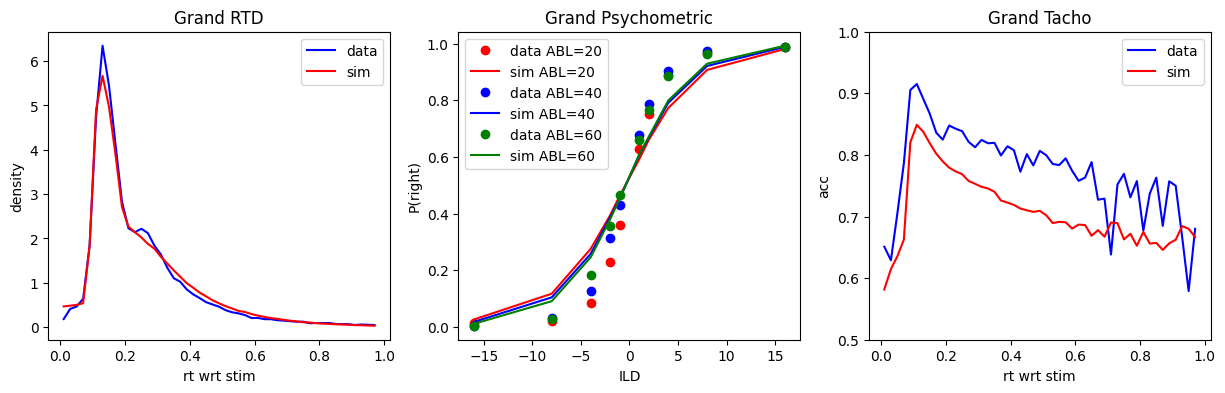

In [27]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# === grand RTD ===
axes[0].plot(bin_centers, grand_rtd(df_led_off_valid_renamed), color='b', label='data')
axes[0].plot(bin_centers, grand_rtd(sim_results_df_valid_less_than_1), color='r', label='sim')
axes[0].legend()
axes[0].set_xlabel('rt wrt stim')
axes[0].set_ylabel('density')
axes[0].set_title('Grand RTD')

# === grand psycho ===
data_psycho = plot_psycho(df_led_off_valid_renamed)
sim_psycho = plot_psycho(sim_results_df_valid_less_than_1)

colors = ['r', 'b', 'g']  # Define colors for each ABL
for i, ABL in enumerate(ABL_arr):
    axes[1].plot(ILD_arr, data_psycho[ABL], color=colors[i], label=f'data ABL={ABL}', marker='o', linestyle='None')
    axes[1].plot(ILD_arr, sim_psycho[ABL], color=colors[i], label=f'sim ABL={ABL}', linestyle='-')

axes[1].legend()
axes[1].set_xlabel('ILD')
axes[1].set_ylabel('P(right)')
axes[1].set_title('Grand Psychometric')

# === grand tacho ===
data_tacho_x, data_tacho_y = plot_tacho(df_led_off_valid_renamed)
sim_tacho_x, sim_tacho_y = plot_tacho(sim_results_df_valid_less_than_1)

axes[2].plot(data_tacho_x, data_tacho_y, color='b', label='data')
axes[2].plot(sim_tacho_x, sim_tacho_y, color='r', label='sim')
axes[2].legend()
axes[2].set_xlabel('rt wrt stim')
axes[2].set_ylabel('acc')
axes[2].set_title('Grand Tacho')
axes[2].set_ylim(0.5, 1);


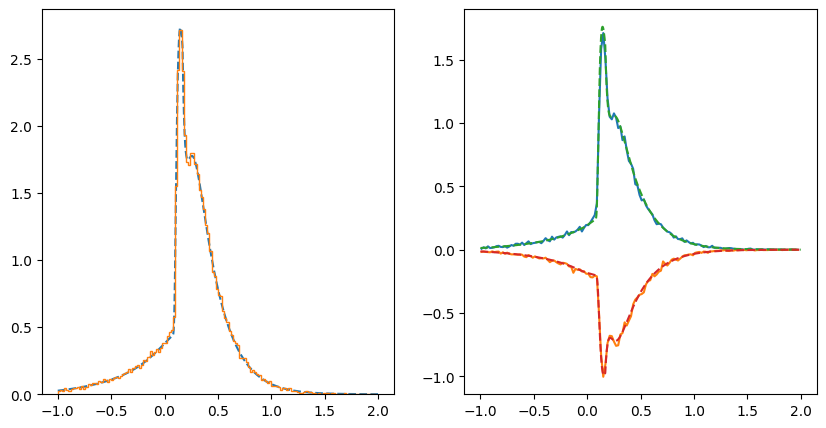

In [81]:
ABL = 20; ILD = 1
sim_results_df_ABL_ILD = sim_results_df[(sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'] == ILD)]
bins = np.arange(-1, 2, 0.02)
rt_ABL_ILD = sim_results_df_ABL_ILD['rt'] - sim_results_df_ABL_ILD['t_stim']


theory_total = np.zeros_like(t_pts)
theory_up = np.zeros_like(t_pts)
theory_down = np.zeros_like(t_pts)

for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    up = up_or_down_RTs_fit_wrt_stim_fn(
        t, 1, P_A, C_A,
        np.nan, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l, is_norm, is_time_vary, K_max)

    down = up_or_down_RTs_fit_wrt_stim_fn(
        t, -1, P_A, C_A,
        np.nan, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l, is_norm, is_time_vary, K_max)

    theory_up[idx]  = up
    theory_down[idx] = down  
    theory_total[idx] = up + down


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(t_pts, theory_total, ls='--')
plt.hist(rt_ABL_ILD, bins=bins, density=True, histtype='step');

plt.subplot(1,2,2)
sim_results_df_ABL_ILD_up = sim_results_df_ABL_ILD[sim_results_df_ABL_ILD['choice'] == 1]
sim_results_df_ABL_ILD_down = sim_results_df_ABL_ILD[sim_results_df_ABL_ILD['choice'] == -1]

up_rt_hist, _ = np.histogram(sim_results_df_ABL_ILD_up['rt'] - sim_results_df_ABL_ILD_up['t_stim'], bins=bins, density=True)
down_rt_hist, _ = np.histogram(sim_results_df_ABL_ILD_down['rt'] - sim_results_df_ABL_ILD_down['t_stim'], bins=bins, density=True)


bin_centers = bins[:-1] + 0.5 * 0.02
plt.plot(bin_centers, up_rt_hist * len(sim_results_df_ABL_ILD_up)/len(sim_results_df_ABL_ILD))
plt.plot(bin_centers, -1 *  down_rt_hist * len(sim_results_df_ABL_ILD_down)/len(sim_results_df_ABL_ILD))


plt.plot(t_pts, theory_up, ls='--')
plt.plot(t_pts, -theory_down, ls='--')


In [82]:
# Convert t_pts to numpy array if it's not already
t_pts = np.array(t_pts)

# Define masks for the integration ranges
mask_full = (t_pts >= -1) & (t_pts <= 2)
mask_pos = (t_pts >= 0) & (t_pts <= 2)

# Compute areas under the curve for full range [-1, 2]
area_up_full = np.trapz(theory_up[mask_full], t_pts[mask_full])
area_down_full = np.trapz(theory_down[mask_full], t_pts[mask_full])
area_total_full = area_up_full + area_down_full

# Compute areas under the curve for positive range [0, 2]
area_up_pos = np.trapz(theory_up[mask_pos], t_pts[mask_pos])
area_down_pos = np.trapz(theory_down[mask_pos], t_pts[mask_pos])
area_total_pos = area_up_pos + area_down_pos

# Print results
print("Area in range [-1, 2]:")
print(f"  Up: {area_up_full:.4f}, Down: {area_down_full:.4f}, Total: {area_total_full:.4f}")

print("Area in range [0, 2]:")
print(f"  Up: {area_up_pos:.4f}, Down: {area_down_pos:.4f}, Total: {area_total_pos:.4f}")


Area in range [-1, 2]:
  Up: 0.5837, Down: 0.4162, Total: 0.9999
Area in range [0, 2]:
  Up: 0.5140, Down: 0.3467, Total: 0.8607


In [71]:
from scipy.integrate import trapezoid as trapz

# Ensure t_pts is a numpy array
t_pts = np.array(t_pts)

# Define masks for the integration ranges
mask_full = (t_pts >= -1) & (t_pts <= 2)
mask_pos = (t_pts >= 0) & (t_pts <= 2)

# Compute areas under the curve for full range [-1, 2]
area_up_full = trapz(theory_up[mask_full], t_pts[mask_full])
area_down_full = trapz(theory_down[mask_full], t_pts[mask_full])
area_total_full = area_up_full + area_down_full

# Compute areas under the curve for positive range [0, 2]
area_up_pos = trapz(theory_up[mask_pos], t_pts[mask_pos])
area_down_pos = trapz(theory_down[mask_pos], t_pts[mask_pos])
area_total_pos = area_up_pos + area_down_pos

# Print results
print("Area in range [-1, 2]:")
print(f"  Up: {area_up_full:.4f}, Down: {area_down_full:.4f}, Total: {area_total_full:.4f}")

print("Area in range [0, 2]:")
print(f"  Up: {area_up_pos:.4f}, Down: {area_down_pos:.4f}, Total: {area_total_pos:.4f}")


Area in range [-1, 2]:
  Up: 0.5830, Down: 0.4169, Total: 0.9999
Area in range [0, 2]:
  Up: 0.5112, Down: 0.3453, Total: 0.8565
